In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 75
epsilon_std = 1.0

In [3]:
x = Input(batch_shape=(batch_size, original_dim))
h_1 = Dense(intermediate_dim, activation="relu")(x)
h = Dense(intermediate_dim, activation="relu")(h_1)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [4]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [5]:
decoder_h1 = Dense(intermediate_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation="sigmoid")
h_decoded_1 = decoder_h1(z)
h_decoded = decoder_h(h_decoded_1)
x_decoded_mean = decoder_mean(h_decoded)

In [6]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

In [7]:
# encoder, from inputs to latent space
encoder = Model(x, z_mean)

In [8]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded_1 = decoder_h1(decoder_input)
_h_decoded = decoder_h(_h_decoded_1)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [32]:
def vae_loss(input_img, output):
    reconstruction_loss = K.sum(K.square(output-input_img))
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.square(K.exp(z_log_sigma)), axis=-1)
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    return total_loss/batch_size

In [33]:
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard

In [34]:
#vae.compile(optimizer=RMSprop(), loss=vae_loss)
vae.compile(optimizer=Adam(), loss=vae_loss)

In [35]:
import shutil, os
logs_path = '/home/user/tensorflow_logs/VAE_naive'
if(os.path.exists(logs_path)):
    print("Removing logs")
    shutil.rmtree(logs_path)

Removing logs


In [36]:
if(os.path.exists(logs_path)):
    print("Removing logs")
    shutil.rmtree(logs_path)

In [37]:
from keras.callbacks import ModelCheckpoint
cb = ModelCheckpoint("VAE_naive/weights.{epoch:02d}-{val_loss:.2f}.hdf5", 
                                     monitor='val_loss', 
                                     verbose=0, 
                                     save_best_only=False, 
                                     save_weights_only=False, 
                                     mode='auto',
                                     period=1)

In [38]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = 1*(x_train.astype('float32') / 255.-0)
x_test = 1*(x_test.astype('float32') / 255.-0)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[TensorBoard(log_dir='/home/user/tensorflow_logs/VAE_naive'), cb]
       )

Train on 60000 samples, validate on 10000 samples
Epoch 1/75
60000/60000 [==============================] - 4s - loss: 46.1895 - val_loss: 38.6901
Epoch 2/75
60000/60000 [==============================] - 4s - loss: 36.9094 - val_loss: 35.4784
Epoch 3/75
60000/60000 [==============================] - 4s - loss: 34.8352 - val_loss: 34.3297
Epoch 4/75
60000/60000 [==============================] - 4s - loss: 33.7642 - val_loss: 33.6051
Epoch 5/75
60000/60000 [==============================] - 3s - loss: 33.0413 - val_loss: 32.9396
Epoch 6/75
60000/60000 [==============================] - 4s - loss: 32.4871 - val_loss: 32.4901
Epoch 7/75
60000/60000 [==============================] - 4s - loss: 32.0693 - val_loss: 32.1523
Epoch 8/75
60000/60000 [==============================] - 4s - loss: 31.7065 - val_loss: 31.9975
Epoch 9/75
60000/60000 [==============================] - 4s - loss: 31.3835 - val_loss: 31.7982
Epoch 10/75
60000/60000 [==============================] - 4s - loss: 31.1185

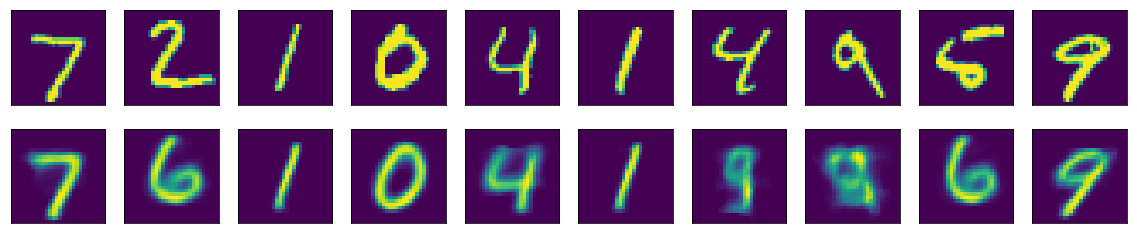

In [39]:
decoded_imgs = vae.predict(x_test, batch_size=batch_size)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

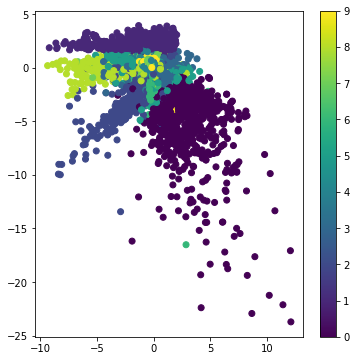

In [40]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

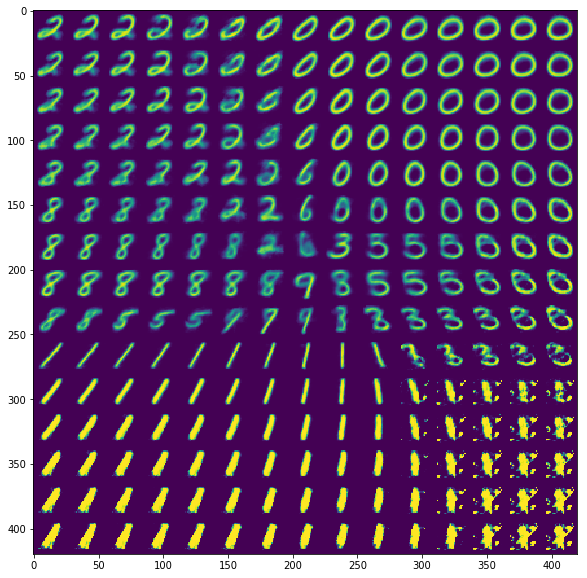

In [41]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-6, 6, n)
grid_y = np.linspace(-6, 6, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]+[0]*(latent_dim-2)]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)

plt.show()

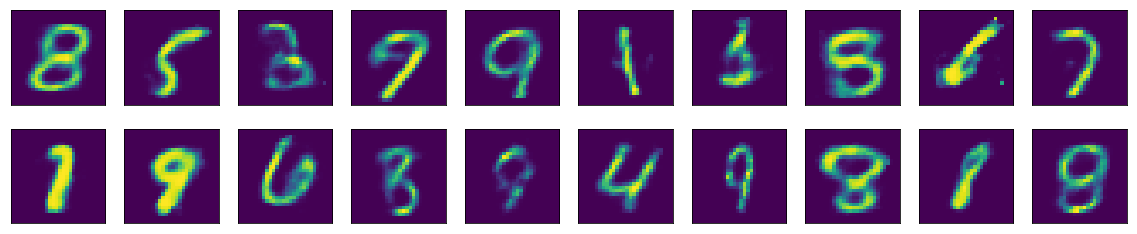

In [79]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(generator.predict(np.random.normal(size=(1, latent_dim), loc=0, scale=1)).reshape(28, 28))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(generator.predict(np.random.normal(size=(1, latent_dim), loc=0, scale=1)).reshape(28, 28))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [80]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 784)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (100, 256)            200960      input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (100, 256)            65792       dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (100, 5)              1285        dense_2[0][0]                    
___________________________________________________________________________________________